<h3>
<center>Crypto Currency and Portfolio Construction</center>
</h3>

<h6>
<p>Ryan Milgrim and Roo Fernando</p>
<p>June, 3, 2024</p>
<p>University of Washington</p>
<p>CFRM 521: Machine Learning</p>
</h6>

### 1. Project Design [20 Points]

- Clear and Percise Problem Statement
- Reasonable Project Goal
- Extra credit of up to 10 points will be given for innovative content

#### Problem Statement

Cryptocurrency markets, first introduced in 2009, have seen widespread adoption, with two countries now recognizing cryptocurrencies as legal tender. Despite their speculative nature, the popularity of these digital assets continues to grow globally. Traditional investment strategies are typically grounded in economic fundamentals such as company earnings and market interest rates. However, applying these principles to cryptocurrencies is challenging due to their decentralized nature, lack of ties to any single entity, and extreme price volatility. This has made constructing and managing cryptocurrency portfolios particularly difficult for traditional investors.

In this project, we aim to develop and demonstrate the application of machine learning methods to construct cryptocurrency strategies that improve returns and reduce the risks associated with these investments. By leveraging these advanced techniques, we seek to provide investors with tools to navigate the highly volatile cryptocurrency markets more effectively, thereby enhancing their ability to make informed investment decisions.

#### Project Goal

The goal of our project is to develop a machine learning model capable of dynamically adjusting a cryptocurrency portfolio using historical prices and additional derived features. This model will either forecast expected prices or returns for our selected cryptocurrencies or suggest optimal allocations among these currencies. To evaluate the utility of these methods, we will implement a systematic investment process based on the model’s outputs and compare its performance against naive portfolio construction methods, such as a buy-and-hold strategy with perfect foresight of future returns (a capability our methods will not assume). If our model can achieve out-of-sample returns that exceed those of any individual cryptocurrency, it would demonstrate that our approach enables investors to make more informed and effective decisions in the cryptocurrency domain.

### 2. Data Processing and Feature Engineering  [25 Points]

#### Reliable and relevant data sources

The data we will be using for our analysis can be found here: <a href="https://www.kaggle.com/code/adityamhaske/crypto-currencies-price-analysis">Kaggle - Crypto Currencies Price Analysis</a>. We have consolidated the four CSV files into a single data.csv file to streamline our notebook. 

The dataset includes historical open, high, low, and closing prices for BTC, ETH, LTC, and XRP from January 1, 2018. Our analysis primarily relies on closing prices to calculate daily returns and other features.

It's important to note that our dataset contains some missing values due to exchange issues. Instead of discarding these rows, we have opted to fill missing prices with the last known price, as this method minimizes data loss and maintains the integrity of our time series.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the datafile and format as a time series.
data = pd.read_csv('data.csv', index_col=1)
data.index = pd.to_datetime(data.index, format='mixed')

# Format the dataset into features denoted as {Coin}__{Feature}
data = data.set_index(['Crypto'], append=True).unstack()
data.columns = [f'{coin}__{ohlc}' for ohlc, coin in data.columns.values]

# Sorting the timeseries by date and imputing missing values. 
data.sort_index()
data = data.ffill()
data.head()

,BTC__Open,ETH__Open,LTC__Open,XRP__Open,BTC__High,ETH__High,LTC__High,XRP__High,BTC__Low,ETH__Low,LTC__Low,XRP__Low,BTC__Close,ETH__Close,LTC__Close,XRP__Close
Date,,,,,,,,,,,,,,,,
2018-01-01,13996.0,744.39,230.32,1.99,14035.0,772.98,237.77,2.10,12860.0,725.10,217.87,1.82,13535.0,757.01,225.63,2.10
2018-01-02,13535.0,758.00,225.34,2.07,15217.0,879.90,265.00,2.22,12956.0,757.01,225.01,1.93,14770.0,864.00,254.60,2.21
2018-01-03,14770.0,861.99,254.60,2.20,15394.0,947.92,261.49,2.90,14589.0,851.00,240.51,2.19,15057.0,938.00,243.00,2.78
2018-01-04,15057.0,937.18,243.01,2.78,15395.0,988.99,246.92,3.35,14225.0,905.01,225.00,2.34,14921.0,942.04,240.00,2.60
2018-01-05,14921.0,942.04,239.99,2.60,16909.0,1009.84,260.00,3.00,14817.0,900.00,236.00,2.15,16828.0,958.00,240.45,2.65


# 2. Data Processing and Feature Engineering  [25 Points]

#### Reasonable data cleaning and preprocessing

For our analysis, we create an additional feature named "Return" representing the day of day change in closign price. To ensure that our dataset is formatted well and free of errors, we visualize the dataset with the below code chunk. 

The code generates a histogram of daily returns and a time series plot of closing prices. Upon reviewing these visualizations, we noticed an unusual pattern in the histogram for XRP. Further inspection revealed that the dataset contains only two decimal places of precision for XRP, which often trades below $1.00. This lack of precision results in XRP frequently showing a 0% daily return.

To address this issue, we have decided to exclude XRP from our analysis and focus on the remaining three cryptocurrencies: BTC, ETH, and LTC

In [34]:
def plot_returns_and_prices(coin, returns, prices):
    """Simple Plot Function to visualize the quality of our data"""

    # Making the plot
    fig, ax = plt.subplots(2, 1)
    returns.hist(bins=100, ax=ax[0])
    prices.plot(ax=ax[1])

    # Apply titles
    ax[0].set_title('Daily Returns')
    ax[1].set_title('Closing Prices')

    # Apply Grids for both plots
    ax[0].grid(True, alpha=0.7, linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--')

    # Apply title and layout
    fig.suptitle(coin)
    plt.tight_layout()

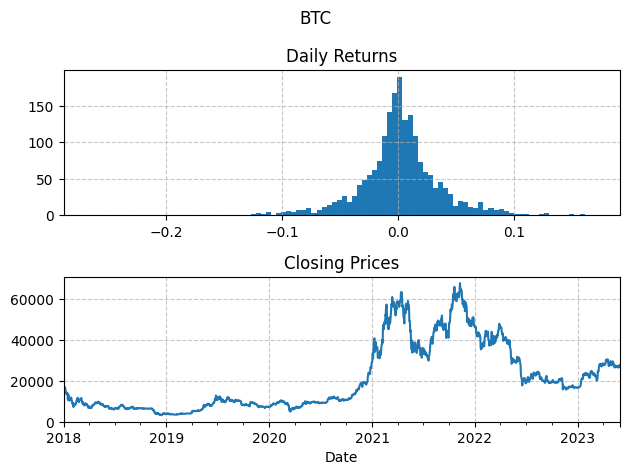

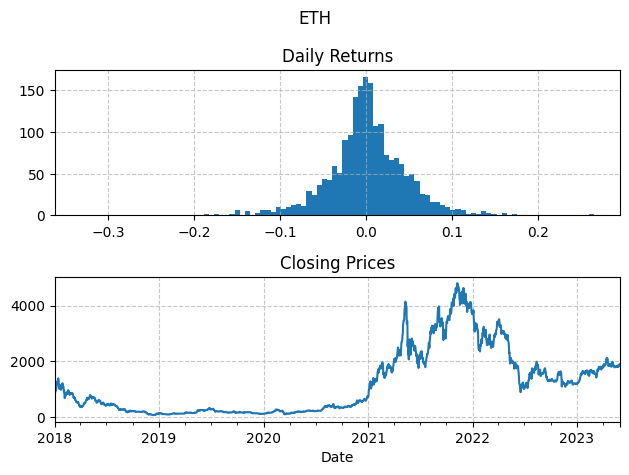

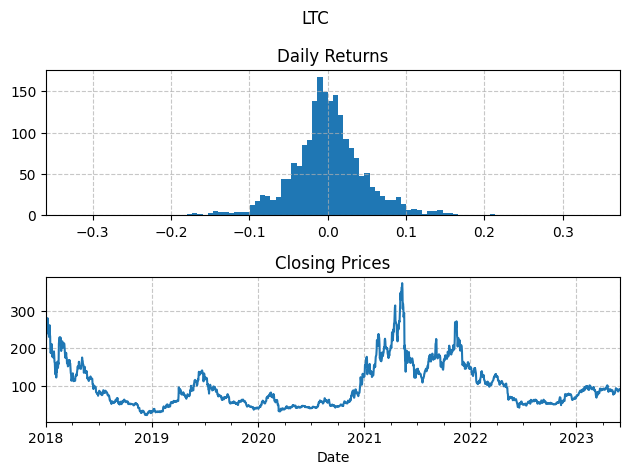

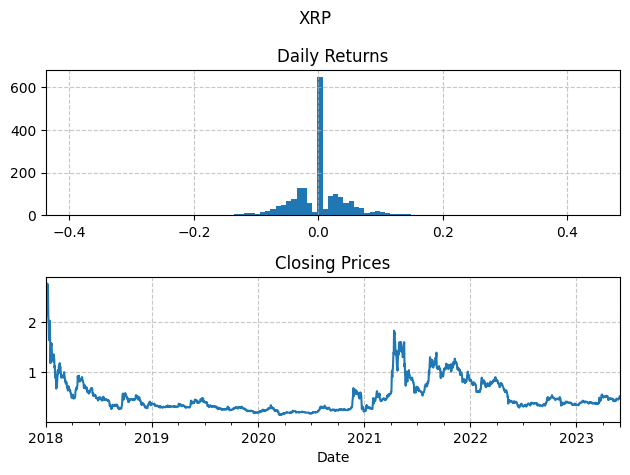

In [35]:
# Plotting the returns and prices for each coin
coins = ['BTC', 'ETH', 'LTC', 'XRP']
for coin in coins:
    coin_returns = f'{coin}__Returns'
    coin_prices = f'{coin}__Close'

    # Appending the new Returns Feature
    data[coin_returns] = data[coin_prices].pct_change()
    plot_returns_and_prices(coin, data[coin_returns], data[coin_prices])

# Droping XRP due to our concerns about data quality.
coins = ['BTC', 'ETH', 'LTC']
data = data.drop(columns=[
    'XRP__Open',
    'XRP__High',
    'XRP__Low',
    'XRP__Close',
    'XRP__Returns',
])

### Effective feature selection and generation

Predicting expectations of the future based on historical open / high / low / close / returns is quite difficult, some would argue impossible without incorpoating additional exogenous data. We did consider incorporating economic variables such as GDP and CPI, however, we have choosen to use technical indicators derived from historical prices instead. The indcators which we utilize are described below:

- **Volatility**: Also known as standard deviation, scaled by the window size of *n* days.

- **Momentum**: This indicator was developed through our own creativity and its calculation can be seen below. This indicator aims to capture how above or below the closing price is relative to the moving average and volatility.

<p>Momentum = <sup>(Close - Moving Average)</sup> / <sub>(Moving Average * Volatility)</sub></p>

We suspect these technical indicators will provide insight into future prices, but this does come with a small cost in terms of data descruction. We considered using a custom transformer class to address the issue of missing data, however our attempts of this led to poor implemtations when it comes to splitting data into training / validation / testing sets. As a result, we will simply drop the first 40 rows of data which contains missing values.

In [36]:
def transform_prices(prices, window=40):
    """Function to transform prices into volatility and momentum indicators."""

    features = pd.DataFrame(index=prices.index)

    # Creating the new features
    features['Returns'] = prices.pct_change()    
    features['MovingAverage'] = prices.rolling(window=window).mean()
    features['Volatility'] = features['Returns'].rolling(window=window).std() * np.sqrt(window)

    # Creating the momentum feature
    features['Momentum'] = prices - features['MovingAverage']
    features['Momentum'] /= features['MovingAverage'] * features['Volatility']

    # Droping features which the function should not append
    features = features.drop(columns=['MovingAverage', 'Returns'])

    # Returning the new features
    return features

# Using the function to append new features to the data
for coin in coins:
    features = transform_prices(data[coin + '__Close'])
    data = pd.concat([data, features.add_prefix(f'{coin}__')], axis=1)

data = data.sort_index(axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1937 entries, 2018-02-10 to 2023-05-31
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BTC__Close       1937 non-null   float64
 1   BTC__High        1937 non-null   float64
 2   BTC__Low         1937 non-null   float64
 3   BTC__Momentum    1937 non-null   float64
 4   BTC__Open        1937 non-null   float64
 5   BTC__Returns     1937 non-null   float64
 6   BTC__Volatility  1937 non-null   float64
 7   ETH__Close       1937 non-null   float64
 8   ETH__High        1937 non-null   float64
 9   ETH__Low         1937 non-null   float64
 10  ETH__Momentum    1937 non-null   float64
 11  ETH__Open        1937 non-null   float64
 12  ETH__Returns     1937 non-null   float64
 13  ETH__Volatility  1937 non-null   float64
 14  LTC__Close       1937 non-null   float64
 15  LTC__High        1937 non-null   float64
 16  LTC__Low         1937 non-null   float64
 

The below code chunk provides a visual of our indicators against the log of the closing price. We show these charts to provide the reader with insight into how our technical indcators behave overtime. 

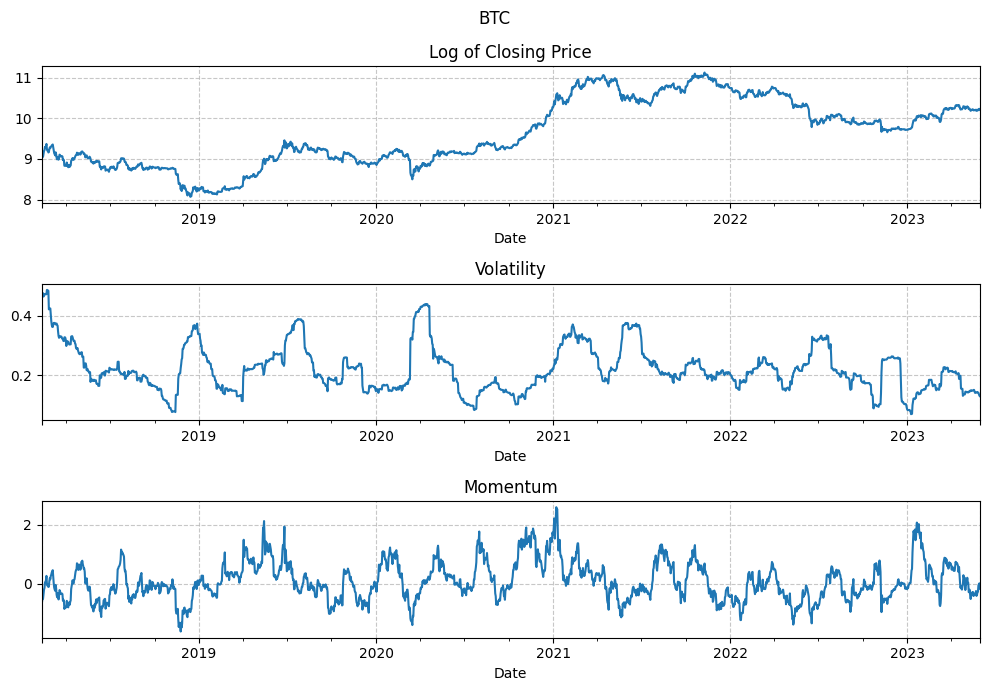

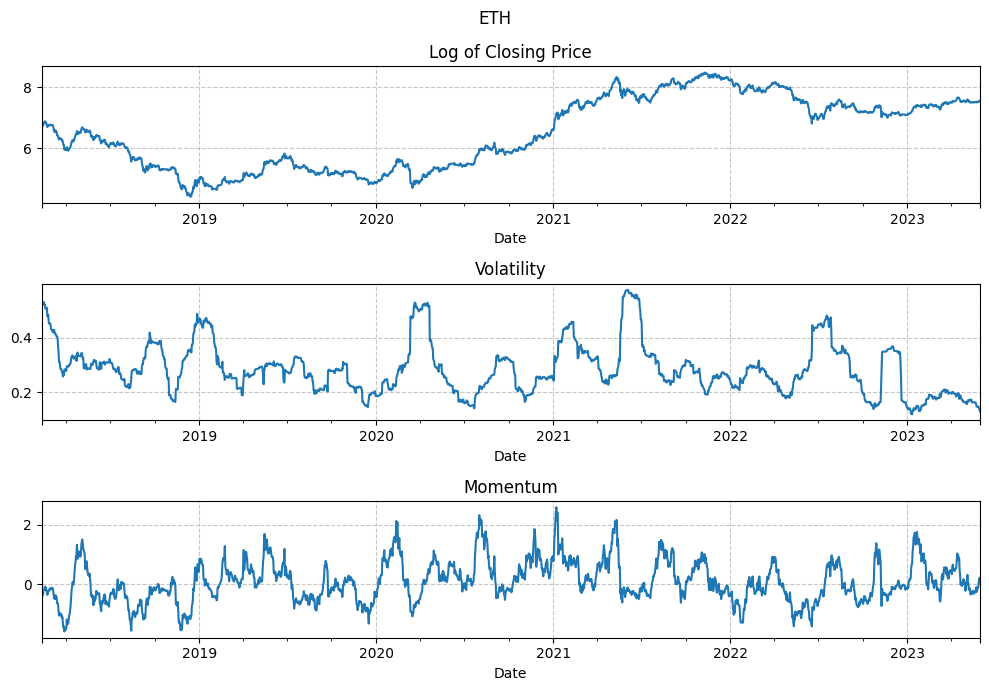

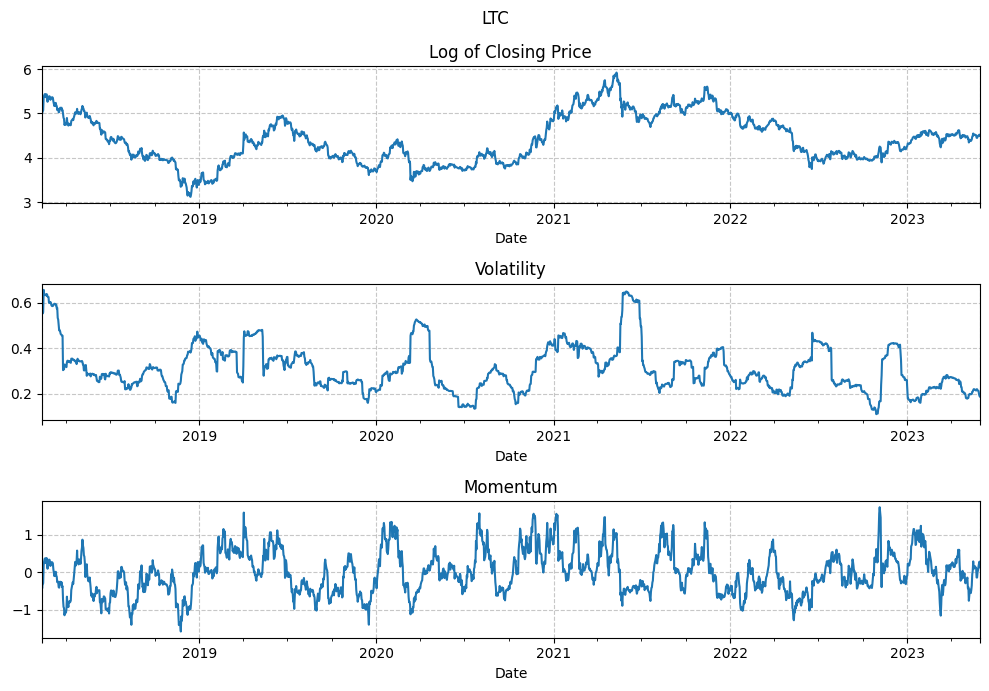

In [37]:
# Plot the technical indicators for each coin against its closing price.
figsize = (10, 7)
for coin in coins:

    # Plot the technical indicators.
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(coin)

    # Plot the log of price, volatility, and momentum.
    np.log(data[f'{coin}__Close']).plot(ax=ax[0], title='Log of Closing Price')
    data[f'{coin}__Volatility'].plot(ax=ax[1], title='Volatility')
    data[f'{coin}__Momentum'].plot(ax=ax[2], title='Momentum')

    # Apply Grids for all axs
    for axi in ax:
        axi.grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

Here we introduce a simple pipeline which applies a robust scaler to our indicators then fits a kmeans model for n_clusters from 2 through 10 to determine the optimal number of clusters. After our analysis, we found that 2 clusters were optimal. 

We also attempted to use a MinMaxScaler and RobustScaler however we found the StandardScaler provided the most stable results when clustering.

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create the pipeline to only momentum and volatility columns
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_init=10))
])

# Create an X dataset with only the technical indicators for regime detection
technical_indicators = [coin + '__Momentum' for coin in coins]
technical_indicators += [coin + '__Volatility' for coin in coins]
X = data[technical_indicators]


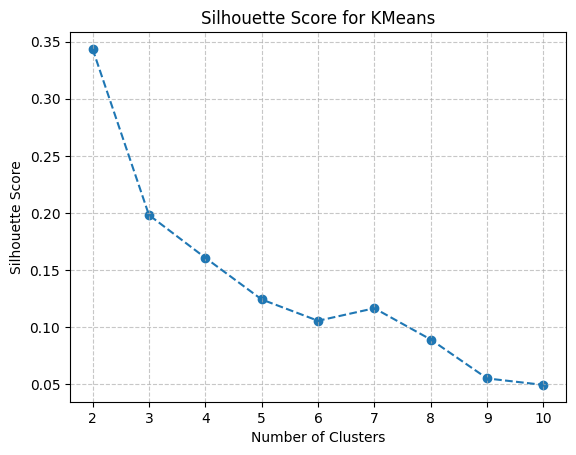

In [75]:
from sklearn.metrics import silhouette_score

# Fit the pipeline to the for n_clusters = {2 - 10} and record silhouette score.
scores = dict()
for n in range(2, 11):
    pipeline.set_params(kmeans__n_clusters=n)
    pipeline.fit(X)
    
    # Transform data to get cluster labels
    labels = pipeline['kmeans'].labels_

    # Calculate the silhouette score
    score = silhouette_score(X, labels)
    scores[n] = score

# Refitting the model to our best found parameter
n_regimes = 2
pipeline.set_params(kmeans__n_clusters=n_regimes)
pipeline.fit(data)

# Plot the scores
fig, ax = plt.subplots()
ax.plot(list(scores.keys()), list(scores.values()), linestyle='--')
ax.scatter(list(scores.keys()), list(scores.values()))
ax.set_title('Silhouette Score for KMeans')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.grid(True, alpha=0.7, linestyle='--')
plt.show()

From the below plots and metrics, it seems reasonable to believe that our, so far simple, model could be useful in navigating financial markets. Using 2 regimes clustered from our technical indicators, it would indicate that BTC is the best coin to hold 74% of the time but if an investor were to partake in market timing, they may earn more by holding ETH.  


Days In:
Regime 0: 505
Regime 1: 1432

Percentage of Time in:
Regime 0: 26.07%
Regime 1: 73.93%

Transition Matrix:
col_0         0         1
row_0                    
0.0    0.990099  0.009901
1.0    0.003494  0.996506


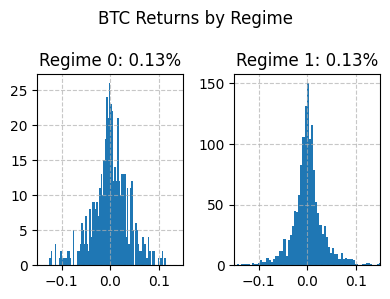

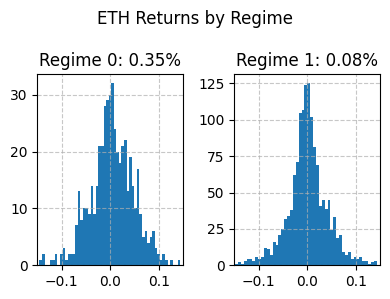

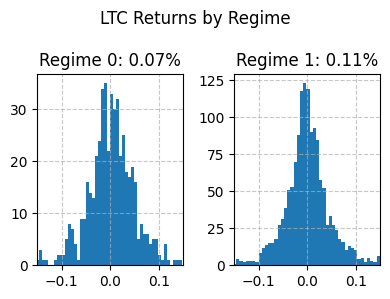

In [76]:
# Assigning a regimes timeseries
regimes = pd.Series(pipeline.predict(data), data.index)
for coin in coins:

    fig, axs = plt.subplots(1, n_regimes, figsize=(2 * n_regimes, 3))
    fig.suptitle(f'{coin} Returns by Regime')

    # Plot a histogram of each regime with the mean return in the title
    for i in range(n_regimes):

        # Filtering down to the coin's returns within the regime
        regime_returns = data.loc[regimes == i, f'{coin}__Returns']

        # Plotting the histogram
        regime_returns.hist(bins=100, ax=axs[i])
        axs[i].set_title(f'Regime {i}: {regime_returns.mean():.2%}')
        axs[i].grid(True, alpha=0.7, linestyle='--')
        axs[i].set_xlim((-0.15, 0.15))

    plt.tight_layout()

# Print the number of days in each regime
print('\nDays In:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts()[i]}')

# Print the percentage of time in each regime
print('\nPercentage of Time in:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts(normalize=True)[i]:.2%}')

# Print a transition matrix. The probability of transitioning from regime a to b
transition_matrix = pd.crosstab(regimes.shift(), regimes, normalize='index')
print('\nTransition Matrix:')
print(transition_matrix)


### 3. Model Selection and Implementation [30 Points]

#### Good reasons for choosing models
#### Reasonable train/test/validation split
#### Clear model training and tuning process
